In [41]:
""" This script is used to compute and plot the amplitudes of the CMS ECAL prototype from the ETH group at the CERN Prevessin site.
The mainly used functions to call from outside the script are down below: run_amplitude_computation.
"""

""" Imports """

import uproot
import numpy as np
import pandas as pd
import glob
import os
import h5py
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from decimal import *
from pathlib import Path


""" Global Variables """

save_folder_global = 'Synchronisation' # Processed data from time delta computation will be stored in a folder named like this. 
                                        # The data from January 2022 is in 'Synchronisation January 2022'
raw_data_folder_global = '/eos/home-s/spigazzi/Lab21/data/Reco/' # Raw data is stored here
variation_save_folder_global = 'Variation Stats ' # Variation plots are saved here
split_name = 'Merged' # Needed for legacy support, namely to be able to run the statistics_plot and variation plot functions 
                    # on the data files from January 2022 with 'Merged in their name'. Obsolete otherwise, split_name could be removed everywhere 

numbers = ['1', '2', '3', '4', '5'] # The five channels on each board
letters = ['C']
# letters = ['A', 'B', 'D', 'E'] # TODO: Add Back 'C' when board 20 (middle board) is back. It was out of order in January 2022

X = numbers.copy() # Used for colormesh plots
Y = letters.copy()
X.insert(0, '0')
Y.insert(0, '0')

channel_names = ['C1', 'C2', 'C3', 'C4', 'C5']
# channel_names = ['A1', 'A2', 'A3', 'A4', 'A5', 
  #               'B1', 'B2', 'B3', 'B4', 'B5', # TODO: Add C when board C returns
   #              'D1', 'D2', 'D3', 'D4', 'D5',
    #             'E1', 'E2', 'E3', 'E4', 'E5']

# TODO: adapt with number of boards
""" Helper Functions """

def gaussian(x, *p):
    A, mu, sigma = p
    return A * np.exp(-(x -mu)**2/(2*sigma**2))


def synchroniser(value):
    """ Function to remove the period shift. Collects the scattered peaks separated by integer multiples of the clock period to one large peak """
    clock_period = 6.238 # nanoseconds    
    window_leniency = 0.5 # How far from the center value the synchroniser should start to act. Minimum Value that makes sense physically: 0.5
    if value > 0:
        while value > clock_period * window_leniency:
            value -= clock_period
    else:
        while value < (-clock_period * window_leniency):
            value += clock_period
    return float(Decimal(value) % Decimal(clock_period))


def to_channel_converter(channel_number):
    """ Converts the channel number to the appropriate Channel. For example 7 -> 'B3'. """
    board_counter = 0
    while channel_number > 4:
        board_counter += 1
        channel_number -= 5
    return f'{letters[board_counter]}{numbers[channel_number]}'


""" Main functions to run from outside script """

def run_amplitude_computation(run_number, save_folder = save_folder_global, raw_data_folder = raw_data_folder_global):
    """ Computes the amplitude for a run. The splits are merged into a single big run number and the time deltas are saved in an h5 file.
    
    run_number -- (string or int) the number of a run, for example '15484'
    save_folder -- (string) folder where the computed data should be stored
    raw_data_folder -- (string) folder where the raw experiment data is located
    """
    
    # Computation with merged data
    folder =  raw_data_folder + str(int(run_number))
    h = uproot.concatenate({folder+'/*.root' : 'digi'}, allow_missing = True)
    
    run_name = os.path.basename(os.path.normpath(folder))
    print('Run: ', run_name, ' Split: ', split_name)
    run_save = save_folder + '/Run ' + run_name + '/' + split_name + '/'
    Path(run_save).mkdir(parents=True, exist_ok=True)

    amp = h['amp_max'] # retrieve the amplitude
    amp_pd = pd.DataFrame(amp)
    print(amp_pd)
    
    for i in range(len(channel_names)): # TODO: adapt with number of boards
        plt.figure()
        border_size = 2000
        #plt.xlim((250,3000))

        hist, bin_edges, _ = plt.hist(amp_pd[i], bins = 1500, label='Amplitude Histogram')
        bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)  
        
        # The fitting process
        guess = [np.max(hist), bin_centers[np.argmax(hist)], 300]
        coeff, covar = curve_fit(gaussian, bin_centers, hist, p0=guess)
        mu = coeff[1]
        mu_error = covar[1,1]
        sigma = coeff[2]
        sigma_error = covar[2,2]
        
        plt.plot(bin_centers, gaussian(bin_centers, *coeff), label='Gaussian Fit')
        plt.axvline(mu, label = f'Mean: {np.around(mu, decimals = 1)} ps', color = 'red')
        sigma_color = 'pink'
        plt.axvline(mu + sigma, label = f'Std Dev: {np.around(sigma, decimals = 1)} ps', color = sigma_color)
        plt.axvline(mu - sigma, color = sigma_color)
        
        plt.title(f'Run: {run_name}, Channel: {channel_names[i]}')
        plt.xlabel('Amplitude (??)')
        plt.ylabel('Occurence (a.u.)')
        plt.legend(loc='best')
            
        plt.show()
        
        
def statistics_plot(run_number, save_folder=save_folder_global, raw_data_folder=raw_data_folder_global, skip_mu=False):
    """ Plots mu and sigma as well as their errors for the amplitude of a designated run in a colormesh plot.
    One has to have run the run_amplitude_computation function on the designated run first before using this function.
    
    run_number -- (string or int) The number of a run, for example '15484'
    save_folder -- (string) Folder where the computed data should be stored
    raw_data_folder -- (string) Folder where the raw experiment data is located
    skip_mu == (boolean) If one is not interested in mu, one can skip plotting it
    """
    
    stat_names = ['Mu', 'Mu error', 'Sigma', 'Sigma_error']
    folder =  raw_data_folder + str(int(run_number))
    run_name = os.path.basename(os.path.normpath(folder))
    print('Run: ', run_name, ' Split: ', split_name)
    run_save = save_folder + '/Run ' + str(run_name) + '/' + split_name + '/'
    Path(run_save).mkdir(parents=True, exist_ok=True)

    for k, ref_channel in enumerate(channel_names):
        with h5py.File(run_save + 'Statistics Split ' + split_name + f' ref_ch {ref_channel}.h5', 'r') as hf:
            statistics = hf[f"stats"][:]
            
        for i in range(len(statistics[0,:])):
            if skip_mu and ((i == 0) or (i ==1)):
                continue
                
            plt.figure()
            stat_data = statistics[:,i].reshape(4,5)
            c = plt.pcolormesh(X, Y, stat_data*1000)
            cb = plt.colorbar(c)
            cb.set_label('Deviation over Channels (ps)')
            plt.title(f'{stat_names[i]}, Run: {run_name}, Split: {split_name}, Reference Channel: {ref_channel}')
            plt.show()
        plt.savefig(run_save + f'Stats Colormesh Ref Channel {to_channel_converter(k)}.pdf', dpi = 300)
            
""" Example uses """       
def example(number):
    if number==1:
        # run_amplitude_computation(15612)
        run_amplitude_computation(15610)
        run_amplitude_computation(15611)
    if number==2:
        statistics_plot(15500)
        
""" January 2022 Data 
One can input these into the variation_plot function, or any of the runs into the run_amplitude_computation function.
"""
# included_runs = [15358, 15359, 15362, 15366] # Power cycle 1
# included_runs = [15384, 15387, 15389, 15390, 15395, 15397, 15400, 15401] Power cycle 2
# included_runs = [15483, 15484, 15487, 15489, 15490, 15491, 15492, 15493, 15500, 15503, 15511, 15513, 15516, 15524, 15525, 15527, 15533, 15541] # Temperature 07.02.2022
# included_runs = [15373, 15387, 15422, 15533] # Variation over several days


' January 2022 Data \nOne can input these into the variation_plot function, or any of the runs into the run_amplitude_computation function.\n'

Run:  15610  Split:  Merged
             0            1            2            3            4
0     2.961907  7960.039062  7053.150879  7411.142090  3191.913330
1     0.114600  8636.952148  7607.917969  8026.838867  3516.325439
2     3.503731  7609.150391  6755.297363  7109.638184  3206.420166
3     4.140314  8261.836914  7300.904785  7700.846191  3301.292480
4    -0.817779  8145.176758  7193.475098  7567.453125  3254.532227
...        ...          ...          ...          ...          ...
2995  1.753093  7687.275879  6753.786621  7157.548828  3167.115967
2996  2.399235  8533.701172  7640.012695  7953.041504  3349.854980
2997  2.311664  8372.945312  7477.823730  7825.833496  3301.474365
2998  2.365557  8422.246094  7470.860352  7873.632324  3428.895752
2999  1.868650  8157.721191  7224.232910  7588.328613  3338.425537

[3000 rows x 5 columns]


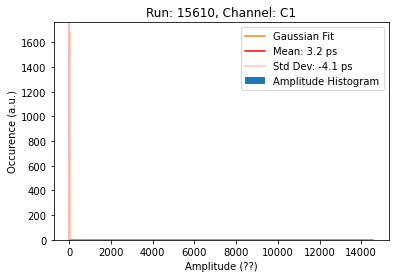

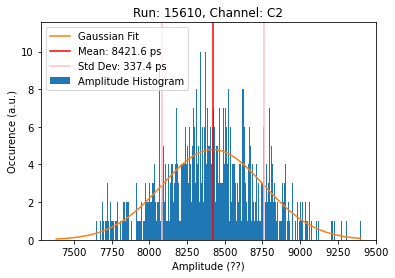

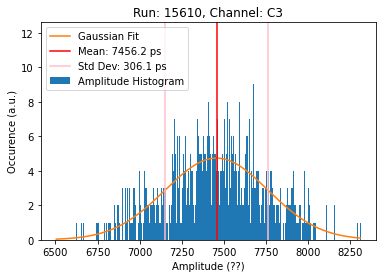

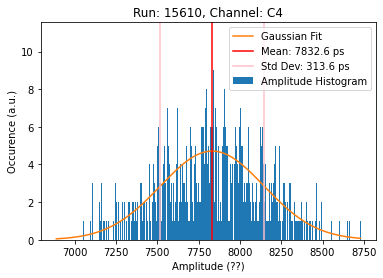

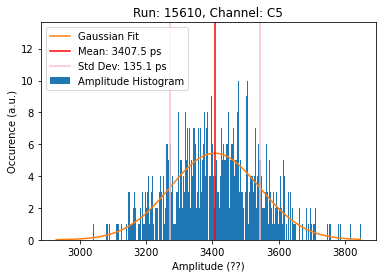

Run:  15611  Split:  Merged
             0            1            2            3            4
0     3.540316  7956.148438  7025.200684  7402.677734  3208.728027
1     3.530400  8014.267578  7091.048828  7458.467285  3350.018311
2     2.797067  8384.150391  7462.075195  7809.224121  3352.302734
3     4.491472  8918.782227  7888.637207  8317.910156  3581.407715
4     4.087907  8234.095703  7021.327148  7657.332520  3409.216553
...        ...          ...          ...          ...          ...
2995  1.491563  8142.390625  7238.345215  7571.110352  3272.573975
2996  4.564464  8601.885742  7641.032227  7996.894531  3441.574463
2997  2.528886  8777.197266  7802.931152  8136.618652  3510.000732
2998  2.467021  8510.844727  7506.662598  7931.251953  3526.266602
2999  3.284571  7463.529785  6642.863770  6990.756836  3184.695801

[3000 rows x 5 columns]


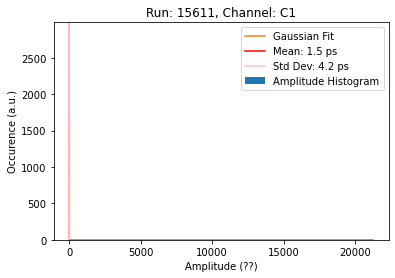

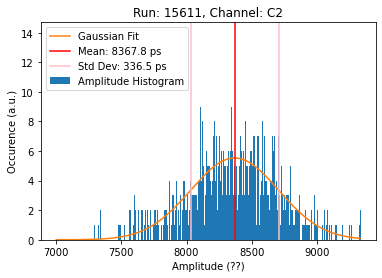

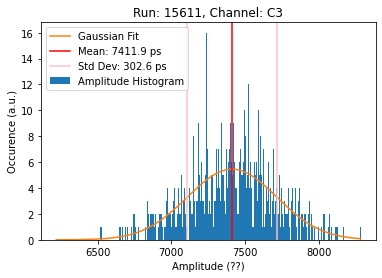

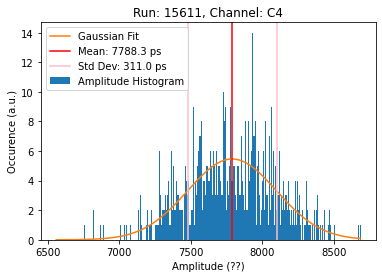

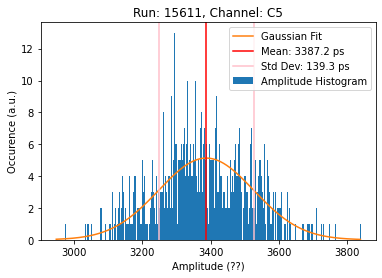

In [42]:
example(1)